In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-xz442kuh
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-xz442kuh
  Resolved https://github.com/albu/albumentations to commit 0dd39463aad7eaa42eb924121f81466b068c894b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 150.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 152.8 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.3-py3-none-any.whl size=150450 sha256=c8ed5f275581cfb910b8eb7faebabe12d60ee3097dc907222d397783db87c21a
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ci5ba1_/wheels/3c/df/16/b3d0d64428c9f25b1ab03989a2e574546d3336647946d31e56
Successfully built alb

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00


In [ ]:
!pip uninstall wandb
!pip install wandb

Found existing installation: wandb 0.16.6
Uninstalling wandb-0.16.6:
  Would remove:
    /usr/local/bin/wandb
    /usr/local/bin/wb
    /usr/local/lib/python3.10/dist-packages/wandb-0.16.6.dist-info/*
    /usr/local/lib/python3.10/dist-packages/wandb/*
Proceed (Y/n)? y
  Successfully uninstalled wandb-0.16.6
  Using cached wandb-0.16.6-py3-none-any.whl (2.2 MB)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from wandb.keras import WandbCallback
import wandb

In [ ]:
!wandb login

wandb: Currently logged in as: veyselsapan1 (centameta). Use `wandb login --relogin` to force relogin


In [ ]:
wandb.init(project="Malaria-Detection", entity="centameta")

wandb: Currently logged in as: veyselsapan1 (centameta). Use `wandb login --relogin` to force relogin


##**Loading Dataset**

In [ ]:
dataset, info = tfds.load('malaria', data_dir='dataset/', as_supervised=True, with_info=True, shuffle_files=True, split=['train'])

In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='dataset/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},
      autho

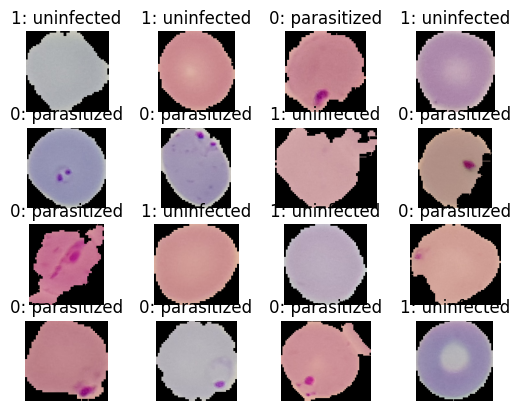

In [ ]:
for i, (image, label) in enumerate(dataset[0].take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(str(label.numpy()) +': '+info.features['label'].int2str(label))
  plt.axis('off')

###**WandB Dataset Versioning**

In [ ]:
def load_original_data():
  with wandb.init(project="Malaria-Detection", entity="centameta") as run:

    original_data = wandb.Artifact(
        name = "new_dataset",
        type="raw_data",
        description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
        metadata = {"source": "TFDS",
                    "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                    "source_code": "tfds.image_classification.Malaria",
                    "version": "1.0.0",
                    "download_size": "337.08 MiB",
                    }
    )

    original_data.add_dir('dataset/')

    run.log_artifact(original_data)

In [ ]:
load_original_data()

wandb: Adding directory to artifact (./dataset)... Done. 19.7s


In [ ]:
IM_SIZE = 224
def resize_rescale(image, label):
    image = tf.image.resize(image, [IM_SIZE, IM_SIZE])  # Resize the image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image to 0-1
    return image, label

In [ ]:
def parse_tfrecord(proto):
    keys_to_features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    image = tf.io.decode_jpeg(parsed_features['image'], channels=3)
    label = parsed_features['label']
    return image, label

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(image, label):
    # Ensure that your serialization function handles the data properly
    if image.dtype != tf.uint8:
        image = tf.cast(image * 255.0, tf.uint8)  # Scale and convert image to uint8

    # Create a dictionary of features
    feature = {
        'image': _bytes_feature(tf.io.encode_jpeg(image)),
        'label': _int64_feature(label)
    }
    # Create an Example, serialize it
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def save_as_tfrecord(dataset, filename):
    # Use tf.io.TFRecordWriter to write the dataset to a TFRecord file
    with tf.io.TFRecordWriter(filename) as writer:
        # Iterate over the dataset
        for img, lbl in dataset:
            # Serialize each example
            example = serialize_example(img, lbl)
            # Write the serialized example to the TFRecord file
            writer.write(example)

In [ ]:
def preprocess_and_debug():
    with wandb.init(project="Malaria-Detection", entity="centameta") as run:
        artifact = run.use_artifact('centameta/Malaria-Detection/new_dataset:v0', type='raw_data')
        artifact_dir = artifact.download()
        artifact_directory = os.path.join(artifact_dir, 'malaria/1.0.0')
        preprocessed_dir = os.path.join(artifact_dir, 'preprocessed/')
        os.makedirs(preprocessed_dir, exist_ok=True)
        dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(artifact_directory + '/*.tfrecord'))
        print("Original Dataset:", dataset)

        # Apply parsing and preprocessing
        dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
        print("After Parsing:", dataset)

        dataset = dataset.map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
        print("After Resizing and Rescaling:", dataset)

        # Optionally, you can take one sample to inspect its shape and type
        for image, label in dataset.take(1):
            print("Sample Image Shape:", image.shape)
            print("Sample Image Dtype:", image.dtype)
            print("Label:", label)

        # Continue with further operations...


In [ ]:
preprocess_and_debug()

wandb: Downloading large artifact new_dataset:v0, 989.81MB. 27569 files... 
wandb:   27569 of 27569 files downloaded.  
Done. 0:0:52.1


Original Dataset: <TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
After Parsing: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
After Resizing and Rescaling: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Sample Image Shape: (224, 224, 3)
Sample Image Dtype: <dtype: 'float32'>
Label: tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
def preprocess_data():
    # Initialize a new wandb run for preprocessing
    with wandb.init(project="Malaria-Detection", entity="centameta") as run:
        # Use the artifact (make sure to specify the correct version)
        artifact = run.use_artifact('centameta/Malaria-Detection/new_dataset:v0', type='raw_data')
        artifact_dir = artifact.download()

        # Define the directory where the original dataset is stored and the directory to save preprocessed images
        artifact_directory = os.path.join(artifact_dir, 'malaria/1.0.0')
        preprocessed_dir = os.path.join(artifact_dir, 'preprocessed/')
        os.makedirs(preprocessed_dir, exist_ok=True)

        # Load dataset
        dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(artifact_directory + '/*.tfrecord'))
        # Parse and preprocess the images
        dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)

        # Convert the dataset to TFRecord format
        tfrecord_filename = os.path.join(preprocessed_dir, 'preprocessed.tfrecord')
        save_as_tfrecord(dataset, tfrecord_filename)

        # Create a new artifact for the preprocessed data
        preprocessed_data = wandb.Artifact(
            name='preprocessed_dataset',
            type='preprocessed_data',
            description='A Preprocessed version of the Malaria dataset stored in TFRecord format'
        )

        # Add the TFRecord file to the artifact
        preprocessed_data.add_file(tfrecord_filename)

        # Log the artifact
        run.log_artifact(preprocessed_data)

In [ ]:
preprocess_data()

wandb: Downloading large artifact new_dataset:v0, 989.81MB. 27569 files... 
wandb:   27569 of 27569 files downloaded.  
Done. 0:0:53.9


In [ ]:
def split_data():
    with wandb.init(project="Malaria-Detection", entity="centameta") as run:
        # Use the preprocessed dataset artifact
        artifact = run.use_artifact('centameta/Malaria-Detection/preprocessed_dataset:v0', type='preprocessed_data')
        artifact_dir = artifact.download()

        # Load and parse preprocessed dataset
        dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(os.path.join(artifact_dir, 'preprocessed.tfrecord')))
        dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

        # Efficiently determining dataset size without fully iterating
        dataset_size = dataset.reduce(0, lambda x, _: x + 1).numpy()
        train_size = int(0.8 * dataset_size)
        val_size = int(0.1 * dataset_size)
        test_size = dataset_size - train_size - val_size

        # Reinitialize dataset after counting
        dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(os.path.join(artifact_dir, 'preprocessed.tfrecord')))
        dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

        # Shuffle and split the dataset
        dataset = dataset.shuffle(buffer_size=10000)
        train_dataset = dataset.take(train_size)
        val_dataset = dataset.skip(train_size).take(val_size)
        test_dataset = dataset.skip(train_size + val_size)

        # Save and log each dataset split as a new TFRecord and a new artifact
        def save_and_log(dataset, name):
            dataset_dir = os.path.join(artifact_dir, name)
            os.makedirs(dataset_dir, exist_ok=True)
            tfrecord_path = os.path.join(dataset_dir, f"{name}.tfrecord")

            # Use tf.io.TFRecordWriter for writing the dataset to a TFRecord
            with tf.io.TFRecordWriter(tfrecord_path) as writer:
                for features in dataset:
                    example = serialize_example(*features)
                    writer.write(example)

            # Create and log the artifact
            data_artifact = wandb.Artifact(
                name=f"{name}_dataset",
                type="preprocessed_data",
                description=f"{name} part of the dataset stored as TFRecord"
            )
            data_artifact.add_file(tfrecord_path)
            run.log_artifact(data_artifact)

        save_and_log(train_dataset, "train_dataset")
        save_and_log(val_dataset, "val_dataset")
        save_and_log(test_dataset, "test_dataset")


In [ ]:
split_data()

wandb: Downloading large artifact preprocessed_dataset:v0, 260.37MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3


In [ ]:
IM_SIZE = 224
transforms = A.Compose(
    [
      A.Resize(IM_SIZE, IM_SIZE),

      A.OneOf([A.HorizontalFlip(),
                A.VerticalFlip(),], p = 0.3),

      A.RandomRotate90(),
      A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2,
                                always_apply=False, p=0.5),
      A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
])
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)
  return image

def augment_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label



In [ ]:
def augment_wandb_data():
    with wandb.init(project="Malaria-Detection", entity="centameta") as run:
        # Use the artifact
        artifact = run.use_artifact('centameta/Malaria-Detection/train_dataset_dataset:v0', type='preprocessed_data')
        artifact_dir = artifact.download()

        # Load and parse dataset
        dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(artifact_dir + '/*.tfrecord'))
        dataset = dataset.map(parse_tfrecord)
        augmented_dataset = dataset.map(augment_data)

        # Define the directory to save the TFRecords
        tfrecord_dir = os.path.join(artifact_dir, "tfrecords")
        os.makedirs(tfrecord_dir, exist_ok=True)
        tfrecord_filename = os.path.join(tfrecord_dir, "augmented_dataset.tfrecord")

        # Save the augmented dataset as TFRecord
        save_as_tfrecord(augmented_dataset, tfrecord_filename)

        # Log the new TFRecord directory as a wandb artifact
        tfrecord_artifact = wandb.Artifact(
            "augmented_tfrecords",
            type="dataset",
            description="Augmented data in TFRecord format"
        )
        tfrecord_artifact.add_dir(tfrecord_dir)
        run.log_artifact(tfrecord_artifact)



In [ ]:
augment_wandb_data()

wandb: Downloading large artifact train_dataset_dataset:v0, 212.01MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
wandb: Adding directory to artifact (/content/artifacts/train_dataset_dataset:v0/tfrecords)... Done. 0.9s


##**Model Creation and Training**

###**Wandb Model Versioning**

In [ ]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 5,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [ ]:
def LeNet_model(config):
  Lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (224, 224, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu',kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= config['N_STRIDES']*2),
    Dropout(rate = config['DROPOUT_RATE'] ),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= 2),

    Flatten(),

    Dense( config['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = config['DROPOUT_RATE']),

    Dense( config['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

  ])


  return Lenet_model

In [ ]:
# Untrained model versioning
def log_model():
  with wandb.init(project="Malaria-Detection", entity="centameta") as run:

    Lenet_model = LeNet_model(CONFIGURATION)
    untrained_model = wandb.Artifact(
        name = "Untrained_model",
        type="model",
        description = "The initial version of lenet model",
        metadata = CONFIGURATION
    )
    filename = 'lenet.h5'
    Lenet_model.save(filename)

    untrained_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(untrained_model)

In [ ]:
log_model()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Training and loggind the model to wandb
def train_and_log():
  with wandb.init(project="Malaria-Detection", entity="centameta") as run:
    # Downloading the augmented training dataset
    train_artifact = run.use_artifact('centameta/Malaria-Detection/augmented_tfrecords:v0', type='dataset')
    train_artifact_dir = train_artifact.download()
    # Downloading the validation dataset
    val_artifact = run.use_artifact('centameta/Malaria-Detection/val_dataset_dataset:v0', type='preprocessed_data')
    val_artifact_dir = val_artifact.download()

    trained_LeNet_model = wandb.Artifact(
        name = "Trained_LeNet_model",
        type="model",
        description = "A trained version of lenet model",
        metadata = CONFIGURATION,
    )

    dataset_train = tf.data.TFRecordDataset(tf.io.gfile.glob(train_artifact_dir + '/*.tfrecord')).map(parse_tfrecord)
    train_dataset = (
        dataset_train
        .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)
    )
    dataset_val = tf.data.TFRecordDataset(tf.io.gfile.glob(val_artifact_dir + '/*.tfrecord')).map(parse_tfrecord)
    val_dataset = (
        dataset_val
        .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)
    )
    artifact = run.use_artifact('centameta/Malaria-Detection/Untrained_model:v0', type='model')
    model_path = artifact.download()
    LeNet_model = tf.keras.models.load_model(model_path + '/lenet.h5')
    metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    LeNet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
          loss = BinaryCrossentropy(),
          metrics = metrics)

    LeNet_model.fit(
        train_dataset,
        validation_data = val_dataset,
        epochs = 20,
        verbose = 1,
        callbacks=[WandbCallback()],
    )

    filename = 'lenet_trained.h5'
    LeNet_model.save(filename)

    trained_LeNet_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(trained_LeNet_model)

In [ ]:
train_and_log()

wandb: Downloading large artifact augmented_tfrecords:v0, 254.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
    689/Unknown - 18s 13ms/step - loss: 0.4071 - tp: 9150.0000 - fp: 2255.0000 - tn: 8812.0000 - fn: 1829.0000 - accuracy: 0.8148 - precision: 0.8023 - recall: 0.8334 - auc: 0.8960

wandb: Adding directory to artifact (/content/wandb/run-20240414_001557-upfvvcho/files/model-best)... Done. 0.2s


689/689 [==============================] - 22s 19ms/step - loss: 0.4071 - tp: 9150.0000 - fp: 2255.0000 - tn: 8812.0000 - fn: 1829.0000 - accuracy: 0.8148 - precision: 0.8023 - recall: 0.8334 - auc: 0.8960 - val_loss: 0.2309 - val_tp: 1320.0000 - val_fp: 129.0000 - val_tn: 1237.0000 - val_fn: 69.0000 - val_accuracy: 0.9281 - val_precision: 0.9110 - val_recall: 0.9503 - val_auc: 0.9687
Epoch 2/20
685/689 [============================>.] - ETA: 0s - loss: 0.2156 - tp: 10179.0000 - fp: 1023.0000 - tn: 9978.0000 - fn: 740.0000 - accuracy: 0.9196 - precision: 0.9087 - recall: 0.9322 - auc: 0.9699

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_001557-upfvvcho/files/model-best)... Done. 0.2s


689/689 [==============================] - 12s 17ms/step - loss: 0.2153 - tp: 10237.0000 - fp: 1027.0000 - tn: 10040.0000 - fn: 742.0000 - accuracy: 0.9198 - precision: 0.9088 - recall: 0.9324 - auc: 0.9700 - val_loss: 0.2113 - val_tp: 1343.0000 - val_fp: 148.0000 - val_tn: 1218.0000 - val_fn: 46.0000 - val_accuracy: 0.9296 - val_precision: 0.9007 - val_recall: 0.9669 - val_auc: 0.9742
Epoch 3/20
686/689 [============================>.] - ETA: 0s - loss: 0.1739 - tp: 10316.0000 - fp: 838.0000 - tn: 10189.0000 - fn: 609.0000 - accuracy: 0.9341 - precision: 0.9249 - recall: 0.9443 - auc: 0.9806

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_001557-upfvvcho/files/model-best)... Done. 0.2s


689/689 [==============================] - 12s 17ms/step - loss: 0.1739 - tp: 10364.0000 - fp: 838.0000 - tn: 10229.0000 - fn: 615.0000 - accuracy: 0.9341 - precision: 0.9252 - recall: 0.9440 - auc: 0.9806 - val_loss: 0.1771 - val_tp: 1307.0000 - val_fp: 84.0000 - val_tn: 1282.0000 - val_fn: 82.0000 - val_accuracy: 0.9397 - val_precision: 0.9396 - val_recall: 0.9410 - val_auc: 0.9795
Epoch 4/20
689/689 [==============================] - 9s 13ms/step - loss: 0.1489 - tp: 10424.0000 - fp: 669.0000 - tn: 10398.0000 - fn: 555.0000 - accuracy: 0.9445 - precision: 0.9397 - recall: 0.9494 - auc: 0.9859 - val_loss: 0.1786 - val_tp: 1317.0000 - val_fp: 97.0000 - val_tn: 1269.0000 - val_fn: 72.0000 - val_accuracy: 0.9387 - val_precision: 0.9314 - val_recall: 0.9482 - val_auc: 0.9770
Epoch 5/20
689/689 [==============================] - 9s 13ms/step - loss: 0.1184 - tp: 10535.0000 - fp: 541.0000 - tn: 10526.0000 - fn: 444.0000 - accuracy: 0.9553 - precision: 0.9512 - recall: 0.9596 - auc: 0.9911 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_001557-upfvvcho/files/model-best)... Done. 0.2s


689/689 [==============================] - 12s 17ms/step - loss: 0.0688 - tp: 10685.0000 - fp: 282.0000 - tn: 10785.0000 - fn: 294.0000 - accuracy: 0.9739 - precision: 0.9743 - recall: 0.9732 - auc: 0.9968 - val_loss: 0.1765 - val_tp: 1309.0000 - val_fp: 74.0000 - val_tn: 1292.0000 - val_fn: 80.0000 - val_accuracy: 0.9441 - val_precision: 0.9465 - val_recall: 0.9424 - val_auc: 0.9767
Epoch 9/20
689/689 [==============================] - 9s 13ms/step - loss: 0.0535 - tp: 10774.0000 - fp: 216.0000 - tn: 10851.0000 - fn: 205.0000 - accuracy: 0.9809 - precision: 0.9803 - recall: 0.9813 - auc: 0.9981 - val_loss: 0.2685 - val_tp: 1360.0000 - val_fp: 133.0000 - val_tn: 1233.0000 - val_fn: 29.0000 - val_accuracy: 0.9412 - val_precision: 0.9109 - val_recall: 0.9791 - val_auc: 0.9712
Epoch 10/20
689/689 [==============================] - 9s 13ms/step - loss: 0.0467 - tp: 10797.0000 - fp: 194.0000 - tn: 10873.0000 - fn: 182.0000 - accuracy: 0.9829 - precision: 0.9823 - recall: 0.9834 - auc: 0.998

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


accuracy,▁▅▆▆▆▇▇▇▇███████████
auc,▁▆▇▇▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
fn,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
fp,█▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
precision,▁▅▅▆▆▇▇▇▇███████████
recall,▁▅▆▆▆▇▇▇▇███████████
tn,▁▅▆▆▆▇▇▇████████████
tp,▁▅▆▆▆▇▇▇▇███████████
val_accuracy,▅▅▆▆▆▅▇▇▆▅▄▄█▅█▁▇▇█▆


##**Hyperparameter Tuning with WandB**

In [ ]:
sweep_config = {
  "name" : "Malaria-Prediction-Sweep",
  "method" : "random",
  "metric": {"name": "accuracy", "goal": "maximize"},
  "parameters": {
    "LEARNING_RATE": {"distribution": "uniform", "min": 1e-4, "max": 1e-2},
    "N_EPOCHS": {"values": [1, 5, 10]},
    "BATCH_SIZE": {"values": [32, 64, 128]},
    "DROPOUT_RATE": {"min": 0.1, "max": 0.4},
    "REGULARIZATION_RATE": {"distribution": "uniform", "min": 0.001, "max": 0.1},
    "N_DENSE_1": {"values": [16, 32, 64, 128]},
    "N_DENSE_2": {"values": [16, 32, 64, 128]},
  }
}
sweep_id = wandb.sweep(sweep_config, project="Malaria-Detection", entity="centameta")

Create sweep with ID: vkk6jvr2
Sweep URL: https://wandb.ai/centameta/Malaria-Detection/sweeps/vkk6jvr2


In [ ]:
def train():
    with wandb.init() as run:
        config = wandb.config  # Accessing configuration for the current run

        # Downloading datasets and model
        train_artifact = run.use_artifact('centameta/Malaria-Detection/augmented_tfrecords:v0', type='dataset')
        train_artifact_dir = train_artifact.download()
        val_artifact = run.use_artifact('centameta/Malaria-Detection/val_dataset_dataset:v0', type='preprocessed_data')
        val_artifact_dir = val_artifact.download()

        # Prepare datasets using the configuration values
        dataset_train = tf.data.TFRecordDataset(tf.io.gfile.glob(train_artifact_dir + '/*.tfrecord')).map(parse_tfrecord)
        train_dataset = dataset_train.shuffle(1024).batch(config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        dataset_val = tf.data.TFRecordDataset(tf.io.gfile.glob(val_artifact_dir + '/*.tfrecord')).map(parse_tfrecord)
        val_dataset = dataset_val.shuffle(1024).batch(config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        # Load and compile the model
        model_artifact = run.use_artifact('centameta/Malaria-Detection/Trained_LeNet_model:v0', type='model')
        model_path = model_artifact.download()
        model = tf.keras.models.load_model(model_path + '/lenet_trained.h5')
        model.compile(optimizer=Adam(learning_rate=config.LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(train_dataset, validation_data=val_dataset, epochs=config.N_EPOCHS, callbacks=[WandbCallback()])


In [ ]:
wandb.agent(sweep_id, function=train, count=5)

wandb: Agent Starting Run: ltyqr610 with config:
wandb: 	BATCH_SIZE: 128
wandb: 	DROPOUT_RATE: 0.3638456972011328
wandb: 	LEARNING_RATE: 0.004080236789467277
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 128
wandb: 	N_EPOCHS: 10
wandb: 	REGULARIZATION_RATE: 0.09670184569970253


wandb: Downloading large artifact augmented_tfrecords:v0, 254.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact Trained_LeNet_model:v0, 55.50MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
      5/Unknown - 4s 43ms/step - loss: 0.0203 - accuracy: 0.9937

    173/Unknown - 11s 42ms/step - loss: 0.0341 - accuracy: 0.9886

wandb: Adding directory to artifact (/content/wandb/run-20240414_002433-ltyqr610/files/model-best)... Done. 0.2s


173/173 [==============================] - 14s 60ms/step - loss: 0.0341 - accuracy: 0.9886 - val_loss: 0.3259 - val_accuracy: 0.9238
Epoch 2/10
173/173 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9889

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_002433-ltyqr610/files/model-best)... Done. 0.2s


173/173 [==============================] - 10s 58ms/step - loss: 0.0340 - accuracy: 0.9889 - val_loss: 0.2313 - val_accuracy: 0.9517
Epoch 3/10
173/173 [==============================] - 8s 45ms/step - loss: 0.0128 - accuracy: 0.9956 - val_loss: 0.2496 - val_accuracy: 0.9390
Epoch 4/10
173/173 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9941

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_002433-ltyqr610/files/model-best)... Done. 0.2s


173/173 [==============================] - 10s 58ms/step - loss: 0.0178 - accuracy: 0.9941 - val_loss: 0.2250 - val_accuracy: 0.9459
Epoch 5/10
173/173 [==============================] - 8s 44ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.2692 - val_accuracy: 0.9466
Epoch 6/10
173/173 [==============================] - 8s 44ms/step - loss: 0.0152 - accuracy: 0.9952 - val_loss: 0.2542 - val_accuracy: 0.9354
Epoch 7/10
173/173 [==============================] - 8s 44ms/step - loss: 0.0091 - accuracy: 0.9966 - val_loss: 0.3889 - val_accuracy: 0.9463
Epoch 8/10
173/173 [==============================] - 8s 44ms/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.2929 - val_accuracy: 0.9525
Epoch 9/10
173/173 [==============================] - 8s 44ms/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.3927 - val_accuracy: 0.9437
Epoch 10/10
173/173 [==============================] - 8s 44ms/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 1.7489 - val_accuracy: 0.5673


accuracy,▁▁▆▅█▆▇█▆▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,██▂▄▁▃▁▁▃▂
val_accuracy,▇████████▁
val_loss,▁▁▁▁▁▁▂▁▂█
accuracy,0.99642
best_epoch,3
best_val_loss,0.22502
epoch,9
loss,0.01186
val_accuracy,0.56733


wandb: Agent Starting Run: 1oojx4ls with config:
wandb: 	BATCH_SIZE: 32
wandb: 	DROPOUT_RATE: 0.29246108204322174
wandb: 	LEARNING_RATE: 0.0008277260939764108
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 64
wandb: 	N_EPOCHS: 10
wandb: 	REGULARIZATION_RATE: 0.018369671887137784


wandb: Downloading large artifact augmented_tfrecords:v0, 254.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact Trained_LeNet_model:v0, 55.50MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
    688/Unknown - 11s 12ms/step - loss: 0.0168 - accuracy: 0.9945

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_002618-1oojx4ls/files/model-best)... Done. 0.2s


689/689 [==============================] - 14s 17ms/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.2517 - val_accuracy: 0.9448
Epoch 2/10
689/689 [==============================] - 9s 13ms/step - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.2967 - val_accuracy: 0.9583
Epoch 3/10
689/689 [==============================] - 9s 13ms/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 0.2638 - val_accuracy: 0.9510
Epoch 4/10
689/689 [==============================] - 9s 13ms/step - loss: 0.0116 - accuracy: 0.9961 - val_loss: 0.2908 - val_accuracy: 0.9539
Epoch 5/10
689/689 [==============================] - 9s 13ms/step - loss: 0.0146 - accuracy: 0.9951 - val_loss: 0.3592 - val_accuracy: 0.9477
Epoch 6/10
689/689 [==============================] - 9s 13ms/step - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.2859 - val_accuracy: 0.9528
Epoch 7/10
689/689 [==============================] - 9s 13ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 0.3099 - val_accuracy: 0.9321
Epoch 8/1

accuracy,▁▇▅▄▂▄▁▅▆█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▄▅▇▆█▄▂▁
val_accuracy,▆█▇▇▆▇▃█▁▆
val_loss,▁▄▂▃▇▃▄▁█▅
accuracy,0.99846
best_epoch,0
best_val_loss,0.25174
epoch,9
loss,0.00511
val_accuracy,0.94955


wandb: Agent Starting Run: c83wmyul with config:
wandb: 	BATCH_SIZE: 32
wandb: 	DROPOUT_RATE: 0.12227106686055464
wandb: 	LEARNING_RATE: 0.002987597507400522
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 64
wandb: 	N_EPOCHS: 1
wandb: 	REGULARIZATION_RATE: 0.04991302426315982


wandb: Downloading large artifact augmented_tfrecords:v0, 254.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact Trained_LeNet_model:v0, 55.50MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


    687/Unknown - 11s 12ms/step - loss: 0.0853 - accuracy: 0.9708

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_002811-c83wmyul/files/model-best)... Done. 0.2s


689/689 [==============================] - 14s 16ms/step - loss: 0.0855 - accuracy: 0.9708 - val_loss: 0.2733 - val_accuracy: 0.9405


accuracy,▁
epoch,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.97079
best_epoch,0
best_val_loss,0.27331
epoch,0
loss,0.0855
val_accuracy,0.94047


wandb: Agent Starting Run: 0dp4nzww with config:
wandb: 	BATCH_SIZE: 128
wandb: 	DROPOUT_RATE: 0.19660037735615896
wandb: 	LEARNING_RATE: 0.009500781810511606
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 16
wandb: 	N_EPOCHS: 5
wandb: 	REGULARIZATION_RATE: 0.08202332907787549


wandb: Downloading large artifact augmented_tfrecords:v0, 254.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact Trained_LeNet_model:v0, 55.50MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5
      5/Unknown - 3s 42ms/step - loss: 0.0147 - accuracy: 0.9969

    173/Unknown - 10s 42ms/step - loss: 0.1107 - accuracy: 0.9628

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_002847-0dp4nzww/files/model-best)... Done. 0.2s


173/173 [==============================] - 13s 59ms/step - loss: 0.1107 - accuracy: 0.9628 - val_loss: 0.2598 - val_accuracy: 0.9045
Epoch 2/5
173/173 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9779

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_002847-0dp4nzww/files/model-best)... Done. 0.2s


173/173 [==============================] - 10s 58ms/step - loss: 0.0601 - accuracy: 0.9779 - val_loss: 0.1906 - val_accuracy: 0.9423
Epoch 3/5
173/173 [==============================] - 8s 45ms/step - loss: 0.0449 - accuracy: 0.9838 - val_loss: 0.2049 - val_accuracy: 0.9361
Epoch 4/5
173/173 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9893

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_002847-0dp4nzww/files/model-best)... Done. 0.2s


173/173 [==============================] - 10s 58ms/step - loss: 0.0328 - accuracy: 0.9893 - val_loss: 0.1835 - val_accuracy: 0.9525
Epoch 5/5
173/173 [==============================] - 8s 44ms/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.2480 - val_accuracy: 0.9162


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▁▇▆█▃
val_loss,█▂▃▁▇
accuracy,0.99501
best_epoch,3
best_val_loss,0.18352
epoch,4
loss,0.01508
val_accuracy,0.91615


wandb: Agent Starting Run: 4u5we7wz with config:
wandb: 	BATCH_SIZE: 32
wandb: 	DROPOUT_RATE: 0.24069163242584848
wandb: 	LEARNING_RATE: 0.003261390917394969
wandb: 	N_DENSE_1: 32
wandb: 	N_DENSE_2: 128
wandb: 	N_EPOCHS: 1
wandb: 	REGULARIZATION_RATE: 0.03024243595327284


wandb: Downloading large artifact augmented_tfrecords:v0, 254.95MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact Trained_LeNet_model:v0, 55.50MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


    688/Unknown - 11s 12ms/step - loss: 0.0972 - accuracy: 0.9662

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240414_002953-4u5we7wz/files/model-best)... Done. 0.2s


689/689 [==============================] - 14s 17ms/step - loss: 0.0972 - accuracy: 0.9662 - val_loss: 0.3210 - val_accuracy: 0.9292


accuracy,▁
epoch,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.96616
best_epoch,0
best_val_loss,0.32099
epoch,0
loss,0.09718
val_accuracy,0.92922


In [ ]:
wandb.finish()